In [34]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 27 13:52:45 2024
Car Price Prediction using CNN with save/load capabilities

@author: Tejinder
@id: 301232634
"""

# ---------------------------- Import Libraries -----------------------------------
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ------------------------- Configurable Parameters ------------------------------
# Model parameters
BATCH_SIZE = 32
EPOCHS = 50
MODEL_CONFIGS = [
    {
        'filters': 64,
        'kernel_size': 3,
        'dropout_rate': 0.2,
        'learning_rate': 0.001
    },
    {
        'filters': 32,
        'kernel_size': 5,
        'dropout_rate': 0.3,
        'learning_rate': 0.0005
    },
    {
        'filters': 128,
        'kernel_size': 3,
        'dropout_rate': 0.1,
        'learning_rate': 0.001
    }
]
PATIENCE = 10

# Create directory for saved models
os.makedirs('/content/drive2/MyDrive/Colab Notebooks/saved_models', exist_ok=True)

# Display options for better output formatting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')

# ---------------------------- Data Loading ------------------------------------
def load_data(file_path):
    """Load and perform initial data checks."""
    try:
        df = pd.read_csv(file_path, on_bad_lines='skip')
        print("File loaded successfully with problematic rows skipped.")
        return df
    except Exception as e:
        print("Error loading file:", e)
        return None

# ------------------------- Exploratory Data Analysis --------------------------
def perform_eda(df):
    """Perform exploratory data analysis and create visualizations."""
    # Basic data info
    print("\nFirst 5 Rows of the Dataset:")
    print(df.head())

    print("\nDataset Info:")
    df.info()

    print("\nSummary Statistics (Numerical Columns):")
    print(df.describe())

    print("\nSummary Statistics (Categorical Columns):")
    print(df.describe(include='object'))

    # Missing values analysis
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / len(df)) * 100
    missing_summary = pd.DataFrame({
        "Missing Count": missing_data,
        "Missing Percentage": missing_percentage
    })
    print("\nMissing Data Summary:")
    print(missing_summary)

    # Create visualizations
    create_visualizations(df)

    return df

def create_visualizations(df):
    """Create and display analysis visualizations."""
    # Correlation Matrix
    plt.figure(figsize=(10, 8))
    corr_matrix = df[['condition', 'odometer', 'year', 'age', 'sellingprice']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title('Correlation Matrix', fontsize=16)
    plt.show()

    # Distribution of Selling Price
    plt.figure(figsize=(10, 6))
    sns.histplot(df['sellingprice'], kde=True, bins=30, color='blue')
    plt.title('Distribution of Selling Price', fontsize=16)
    plt.xlabel('Selling Price', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Odometer vs Selling Price
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['odometer'], y=df['sellingprice'], alpha=0.6, color='green')
    plt.title('Odometer vs Selling Price', fontsize=16)
    plt.xlabel('Odometer (miles)', fontsize=12)
    plt.ylabel('Selling Price', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# ------------------------- Data Preprocessing --------------------------------
def preprocess_data(df, test_size=0.2, random_state=42):
    """Preprocess the car dataset using the successful approach."""
    # Define columns (using successful version's columns)
    relevant_cols = ['year', 'age', 'make', 'model', 'trim', 'body', 'transmission',
                    'condition', 'odometer', 'saledate', 'sellingprice']

    # Select relevant columns
    df = df[relevant_cols]

    # Drop rows with missing values
    df.dropna(subset=relevant_cols, inplace=True)

    # Extract features from saledate
    df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')
    df['sale_month'] = df['saledate'].dt.month
    df['sale_day_of_week'] = df['saledate'].dt.dayofweek
    df.drop('saledate', axis=1, inplace=True)

    # Label encode categorical features
    categorical_columns = ['make', 'model', 'trim', 'body', 'transmission']
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

    # Normalize numerical features
    scaler = MinMaxScaler()
    numerical_columns = ['year', 'condition', 'odometer', 'sale_month', 'sale_day_of_week']
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    # Separate features and target
    X = df.drop('sellingprice', axis=1).values
    y = df['sellingprice'].values

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test, label_encoders, scaler

# ------------------------- Model Architecture --------------------------------
def create_cnn_model(input_shape, config):
    """Create a CNN model with the specified configuration."""
    model = Sequential()

    # Input layer
    model.add(Conv1D(filters=config['filters'], kernel_size=config['kernel_size'],
               activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(config['dropout_rate']))

    # Hidden layers
    model.add(Conv1D(filters=config['filters'] * 2, kernel_size=config['kernel_size'],
               activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(config['dropout_rate'] + 0.1))

    model.add(Conv1D(filters=config['filters'] * 4, kernel_size=config['kernel_size'],
               activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(config['dropout_rate'] + 0.2))

    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=config['learning_rate']),
                 loss='mse', metrics=['mae'])

    return model

# ------------------------- Model Management ----------------------------------
def save_history(history, model_name):
    """Save training history to JSON file."""
    history_path = os.path.join('/content/drive2/MyDrive/Colab Notebooks/saved_models', f"{model_name}_history.json")
    with open(history_path, 'w') as f:
        json.dump(history, f)

def load_history(model_name):
    """Load training history from JSON file."""
    history_path = os.path.join('/content/drive2/MyDrive/Colab Notebooks/saved_models', f"{model_name}_history.json")
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            return json.load(f)
    return None

def load_or_create_model(model_name, input_shape, config):
    """Load existing model or create new one if it doesn't exist."""
    model_path = os.path.join('/content/drive2/MyDrive/Colab Notebooks/saved_models', f"{model_name}.keras")

    if os.path.exists(model_path):
        print(f"Loading existing model: {model_path}")
        return load_model(model_path), load_history(model_name)
    else:
        print(f"Creating new model: {model_name}")
        return create_cnn_model(input_shape, config), None

# ------------------------- Model Training ------------------------------------
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, model_name, history, save_history_func):
        super().__init__()
        self.model_name = model_name
        self.history = history  # This is a dictionary
        self.save_history_func = save_history_func

    def on_epoch_end(self, epoch, logs=None):
        # Append logs for the current epoch to the history dictionary
        if logs:
            for key, value in logs.items():
                if key not in self.history:
                    self.history[key] = []
                self.history[key].append(value)

        # Save the updated history dictionary
        self.save_history_func(self.history, self.model_name)

def train_and_evaluate_model(model_num, X_train_cnn, y_train, X_test_cnn, y_test, config):
    """Train and evaluate a single model with save/load capability."""
    model_name = f"model_{model_num}"
    print(f"\nProcessing {model_name} - Configuration {model_num}")

    # Load or create the model and its history
    model, existing_history = load_or_create_model(
        model_name,
        input_shape=(X_train_cnn.shape[1], 1),
        config=config
    )

    # Determine the initial_epoch from existing history
    if existing_history and 'loss' in existing_history:
        initial_epoch = len(existing_history['loss'])
    else:
        initial_epoch = 0

    print(f"Starting training from epoch {initial_epoch + 1} to {EPOCHS}.")

    # Create callbacks
    save_history_callback = SaveHistoryCallback(model_name, existing_history or {}, save_history)
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            f'/content/drive2/MyDrive/Colab Notebooks/saved_models/{model_name}.keras',
            monitor='val_loss',
            save_best_only=True,  # Ensures only the best model is saved
            verbose=1
        ),
        save_history_callback
    ]

    # Train the model
    history = model.fit(
        X_train_cnn, y_train,
        validation_data=(X_test_cnn, y_test),
        epochs=EPOCHS,            # Total epochs to train
        initial_epoch=initial_epoch,  # Resume from the last completed epoch
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate the model
    y_pred = model.predict(X_test_cnn)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

    print(f"\nModel {model_num} Evaluation:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return model, history

def compare_models(model_names):
    """Load and compare the specified trained models by their names."""
    histories = []
    display_names = []

    # Load each model's history based on the provided names
    for name in model_names:
        history = load_history(name)
        if history:
            histories.append(history)
            display_names.append(name)
        else:
            print(f"No history found for model: {name}")

    # Only plot if at least two models have history
    if len(histories) > 1:
        plt.figure(figsize=(12, 4))

        # Plot training loss comparison
        plt.subplot(1, 2, 1)
        for i, hist in enumerate(histories):
            if 'loss' in hist:
                plt.plot(hist['loss'], label=display_names[i])
        plt.title('Training Loss Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot validation loss comparison if available
        plt.subplot(1, 2, 2)
        for i, hist in enumerate(histories):
            if 'val_loss' in hist:
                plt.plot(hist['val_loss'], label=display_names[i])
        plt.title('Validation Loss Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough trained models found for comparison")



In [15]:
# ------------------------- Modular Execution Steps ----------------------------------
# ------------------------- Execution Steps ----------------------------------
"""
These steps should be run in separate cells in a Jupyter notebook for better control
and ability to save intermediate results
"""

# Step 1: Load and explore data
file_path = '/content/drive2/MyDrive/Colab Notebooks/car_prices.csv'
cars_df = load_data(file_path)

# Calculate age before EDA
cars_df['saledate'] = pd.to_datetime(cars_df['saledate'], utc=True)
cars_df['age'] = cars_df['saledate'].dt.year - cars_df['year']

File loaded successfully with problematic rows skipped.


<ipython-input-15-1a46668409e0>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cars_df['saledate'] = pd.to_datetime(cars_df['saledate'], utc=True)



First 5 Rows of the Dataset:
   year  make         model             trim     body  transmission        vin         state  condition  odometer color  interior                  seller                   mmr   sellingprice          saledate          age
0  2015    Kia              Sorento          LX    SUV   automatic   5xyktca69fg566472   ca      5.0      16639.0  white   black                  kia motors america, inc  20500      21500    2014-12-16 04:30:00+00:00  -1 
1  2015    Kia              Sorento          LX    SUV   automatic   5xyktca69fg561319   ca      5.0       9393.0  white   beige                  kia motors america, inc  20800      21500    2014-12-16 04:30:00+00:00  -1 
2  2014    BMW             3 Series  328i SULEV  Sedan   automatic   wba3c1c51ek116351   ca      4.5       1331.0   gray   black   financial services remarketing (lease)  31900      30000    2015-01-14 20:30:00+00:00   1 
3  2015  Volvo                  S60          T5  Sedan   automatic   yv1612tb4f131

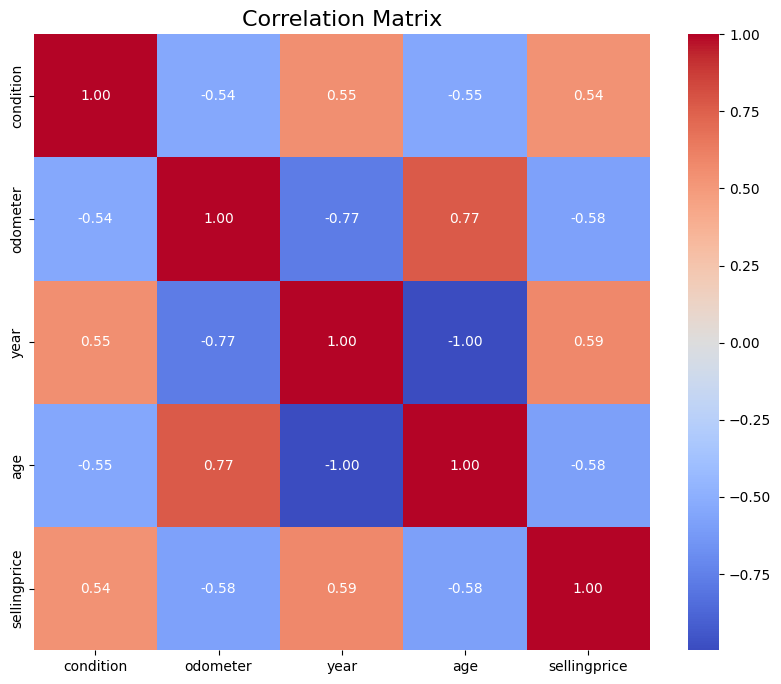

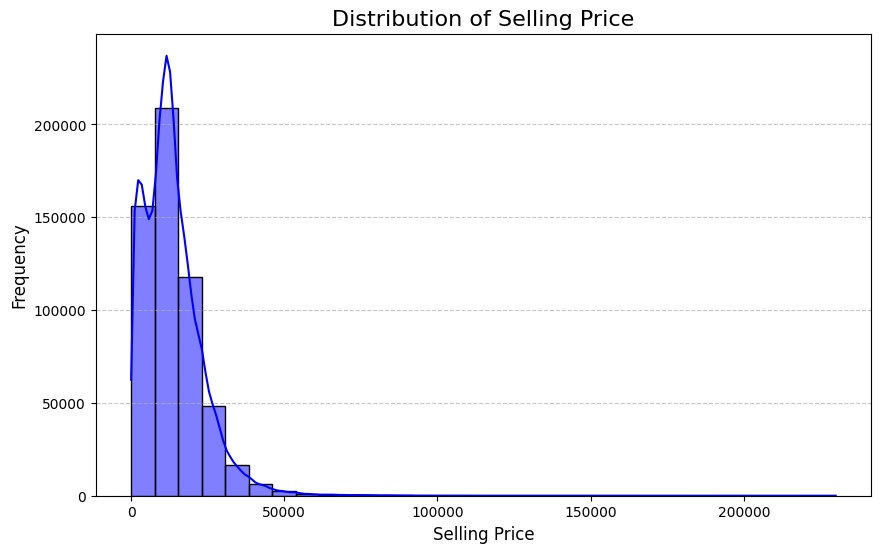

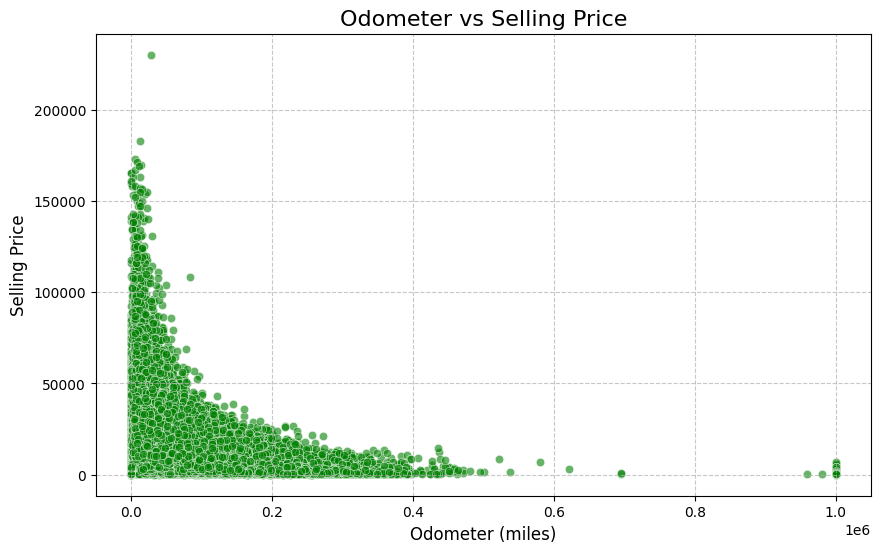

In [ ]:
cars_df = perform_eda(cars_df)

In [16]:
# Step 2: Preprocess data
X_train, X_test, y_train, y_test, encoder, scaler = preprocess_data(cars_df)

# Step 3: Reshape data for CNN
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

<ipython-input-14-1eb622badb7e>:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=relevant_cols, inplace=True)
<ipython-input-14-1eb622badb7e>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')
<ipython-input-14-1eb622badb7e>:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [17]:
# Step 4: Train Model 1
# This will load existing model if available, or create new one if not
print("\nProcessing Model 1 - Conservative Configuration")
model1, history1 = train_and_evaluate_model(
    model_num=1,
    X_train_cnn=X_train_cnn,
    y_train=y_train,
    X_test_cnn=X_test_cnn,
    y_test=y_test,
    config=MODEL_CONFIGS[0]
)


Processing Model 1 - Conservative Configuration

Processing model_1 - Configuration 1
Loading existing model: /content/drive2/MyDrive/Colab Notebooks/saved_models/model_1.keras
Starting training from epoch 51 to 50.
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

Model 1 Evaluation:
R² Score: 0.7961
MAPE: 37.82%


In [18]:
# Step 5: Train Model 2
print("\nProcessing Model 2 - Moderate Configuration")
model2, history2 = train_and_evaluate_model(
    model_num=2,
    X_train_cnn=X_train_cnn,
    y_train=y_train,
    X_test_cnn=X_test_cnn,
    y_test=y_test,
    config=MODEL_CONFIGS[1]
)


Processing Model 2 - Moderate Configuration

Processing model_2 - Configuration 2
Loading existing model: /content/drive2/MyDrive/Colab Notebooks/saved_models/model_2.keras
Starting training from epoch 51 to 50.
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

Model 2 Evaluation:
R² Score: 0.6951
MAPE: 45.95%


In [19]:
# Step 6: Train Model 3
print("\nProcessing Model 3 - Aggressive Configuration")
model3, history3 = train_and_evaluate_model(
    model_num=3,
    X_train_cnn=X_train_cnn,
    y_train=y_train,
    X_test_cnn=X_test_cnn,
    y_test=y_test,
    config=MODEL_CONFIGS[2]
)


Processing Model 3 - Aggressive Configuration

Processing model_3 - Configuration 3
Loading existing model: /content/drive2/MyDrive/Colab Notebooks/saved_models/model_3.keras
Starting training from epoch 36 to 50.
Epoch 36/50
11821/11822 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26108442.0000 - mae: 3102.1958
Epoch 36: val_loss improved from inf to 521398688.00000, saving model to /content/drive2/MyDrive/Colab Notebooks/saved_models/model_3.keras
11822/11822 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 26108456.0000 - mae: 3102.1968 - val_loss: 521398688.0000 - val_mae: 2706.9756
Epoch 37/50
11801/11822 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26044312.0000 - mae: 3099.9729
Epoch 37: val_loss improved from 521398688.00000 to 324732256.00000, saving model to /content/drive2/MyDrive/Colab Notebooks/saved_models/model_3.keras
11822/11822 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 26044018.0000 - mae: 3099.9536 - val_loss: 324732256.0000 - val_mae: 2697.0220
Epoch 38/50
11801/11822 ━━━━━━━━━━━


Comparing available trained models...


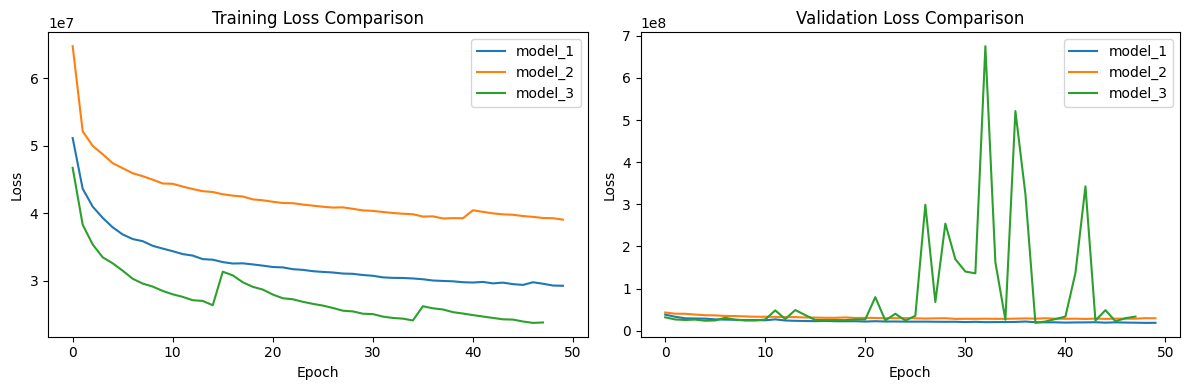

In [20]:
# Step 7: Compare all available models
# This can be run even if only some models are trained
print("\nComparing available trained models...")
compare_models(['model_1', 'model_2', 'model_3'])



Comparing available trained models...


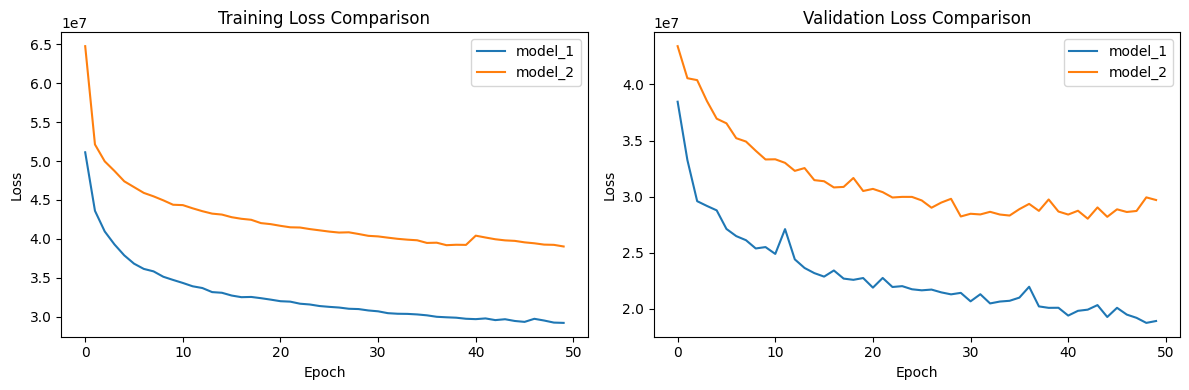

In [21]:
print("\nComparing available trained models...")
compare_models(['model_1', 'model_2'])


In [22]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# ------------------------- History Saving/Loading -------------------------
def save_history(history, model_name):
    """Save training history (dict) to JSON file."""
    history_path = os.path.join('/content/drive2/MyDrive/Colab Notebooks/saved_models', f"{model_name}_history.json")
    with open(history_path, 'w') as f:
        json.dump(history, f)

def load_history(model_name):
    """Load training history from JSON file, return dict or None."""
    history_path = os.path.join('/content/drive2/MyDrive/Colab Notebooks/saved_models', f"{model_name}_history.json")
    if os.path.exists(history_path) and os.path.getsize(history_path) > 0:
        with open(history_path, 'r') as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                print(f"Warning: Corrupted history file {history_path}, starting fresh.")
                return None
    return None

# ------------------------- SaveHistoryCallback -------------------------
class SaveHistoryCallback(Callback):
    def __init__(self, model_name, history, save_history_func):
        super().__init__()
        self.model_name = model_name
        self.history = history if history is not None else {}
        self.save_history_func = save_history_func

    def on_epoch_end(self, epoch, logs=None):
        if logs:
            for key, value in logs.items():
                if key not in self.history:
                    self.history[key] = []
                self.history[key].append(value)
        self.save_history_func(self.history, self.model_name)

# ------------------------- Autoencoder Creation -------------------------
def create_autoencoder(input_shape, config):
    """Create autoencoder for feature extraction."""
    encoder = Sequential([
        Conv1D(config['filters'][0], config['kernel_size'], activation='relu',
               padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv1D(config['filters'][1], config['kernel_size'], activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(config['filters'][2], config['kernel_size'], activation='relu', padding='same'),
        BatchNormalization(),
        Flatten(),
        Dense(config['encoding_dim'], activation='relu', name='encoder_output')
    ])

    decoder = Sequential([
        Dense(input_shape[0] * config['filters'][2], activation='relu'),
        Reshape((input_shape[0], config['filters'][2])),
        Conv1D(config['filters'][2], config['kernel_size'], activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(config['filters'][1], config['kernel_size'], activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(config['filters'][0], config['kernel_size'], activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(1, config['kernel_size'], activation='linear', padding='same')
    ])

    autoencoder = Sequential([encoder, decoder])
    autoencoder.compile(
        optimizer=Adam(learning_rate=config['learning_rate']),
        loss='mse'
    )
    return autoencoder, encoder

def load_or_create_autoencoder(model_name, input_shape, config):
    """Load existing autoencoder or create new one if it doesn't exist."""
    model_path = os.path.join('/content/drive2/MyDrive/Colab Notebooks/saved_models', f"{model_name}.keras")
    history = load_history(model_name)
    if os.path.exists(model_path):
        print(f"Loading existing autoencoder: {model_path}")
        autoencoder = load_model(model_path)
        # Extract encoder part
        encoder = Sequential(autoencoder.layers[0].layers)
        encoder.build(input_shape=(None, *input_shape))
        return autoencoder, encoder, history
    else:
        print(f"Creating new autoencoder: {model_name}")
        autoencoder, encoder = create_autoencoder(input_shape, config)
        return autoencoder, encoder, history

def train_autoencoder(model_name, X_train, config):
    """Train the autoencoder with incremental history saving."""
    input_shape = (X_train.shape[1], 1)
    autoencoder, encoder, existing_history = load_or_create_autoencoder(model_name, input_shape, config)

    # Determine initial_epoch
    if existing_history and 'loss' in existing_history:
        initial_epoch = len(existing_history['loss'])
    else:
        initial_epoch = 0

    save_history_callback = SaveHistoryCallback(model_name, existing_history, save_history)

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=config['patience'],
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            os.path.join('/content/drive2/MyDrive/Colab Notebooks/saved_models', f"{model_name}.keras"),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        save_history_callback
    ]

    history_obj = autoencoder.fit(
        X_train, X_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_split=0.2,
        initial_epoch=initial_epoch,
        callbacks=callbacks,
        verbose=1
    )

    # After training completes, history is saved incrementally, no extra action needed.
    return autoencoder, encoder

# ------------------------- CNN Model (Transfer Learning) -------------------------
def create_cnn_model(input_shape, filters, kernel_size, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Conv1D(filters=filters*2, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate + 0.1))

    model.add(Conv1D(filters=filters*4, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate + 0.2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, epochs, batch_size):
    # For simplicity, we can just train from scratch here or implement a similar history-saving mechanism
    # If desired, you can also implement the SaveHistoryCallback for this model.
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint(os.path.join('/content/drive2/MyDrive/Colab Notebooks/saved_models', f"{model_name}.keras"), monitor='val_loss', save_best_only=True, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f"R² Score: {r2:.4f}")

    return history

In [23]:
# ------------------------- Feature Extraction and Transfer Learning ----------------------
# Assuming X_train_cnn, X_test_cnn, y_train, y_test are already defined.

AUTOENCODER_CONFIG = {
    'filters': [32, 16, 8],
    'kernel_size': 3,
    'learning_rate': 0.001,
    'encoding_dim': X_train_cnn.shape[1] // 3,  # Reducing features to 1/3
    'batch_size': 64,
    'epochs': 50,
    'patience': 5
}

# Train or load autoencoder
print("\nStarting Feature Extraction...")
autoencoder, encoder = train_autoencoder('autoencoder', X_train_cnn, AUTOENCODER_CONFIG)


Starting Feature Extraction...
Loading existing autoencoder: /content/drive2/MyDrive/Colab Notebooks/saved_models/autoencoder.keras
Epoch 23/50
4729/4729 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65.2655
Epoch 23: val_loss improved from inf to 48.48947, saving model to /content/drive2/MyDrive/Colab Notebooks/saved_models/autoencoder.keras
4729/4729 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 65.2660 - val_loss: 48.4895
Epoch 24/50
4729/4729 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67.4826
Epoch 24: val_loss did not improve from 48.48947
4729/4729 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 67.4822 - val_loss: 50.8465
Epoch 25/50
4728/4729 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.2611
Epoch 25: val_loss improved from 48.48947 to 45.12196, saving model to /content/drive2/MyDrive/Colab Notebooks/saved_models/autoencoder.keras
4729/4729 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 65.2608 - val_loss: 45.1220
Epoch 26/50
4719/4729 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.4552
Epoch 26: val_l

In [24]:
# Extract features
X_train_encoded = encoder.predict(X_train_cnn)
X_test_encoded = encoder.predict(X_test_cnn)

# Reshape for CNN input
X_train_encoded = X_train_encoded.reshape((X_train_encoded.shape[0], X_train_encoded.shape[1], 1))
X_test_encoded = X_test_encoded.reshape((X_test_encoded.shape[0], X_test_encoded.shape[1], 1))

11822/11822 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [25]:
EPOCHS = 50
BATCH_SIZE = 32

# Select the best model config (e.g., model 1 is at index 0)
best_model_config = MODEL_CONFIGS[0]

print("\nTraining model with extracted features...")
cnn_transfer = create_cnn_model(
    input_shape=(X_train_encoded.shape[1], 1),
    filters=best_model_config['filters'],
    kernel_size=best_model_config['kernel_size'],
    dropout_rate=best_model_config['dropout_rate'],
    learning_rate=best_model_config['learning_rate']
)

history_transfer = train_and_evaluate_model(
    cnn_transfer,
    "Transfer_Learning_Model",
    X_train_encoded,
    y_train,
    X_test_encoded,
    y_test,
    EPOCHS,
    BATCH_SIZE
)



Training model with extracted features...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11810/11822 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109361456.0000 - mae: 7562.1494
Epoch 1: val_loss improved from inf to 84948128.00000, saving model to /content/drive2/MyDrive/Colab Notebooks/saved_models/Transfer_Learning_Model.keras
11822/11822 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 109347080.0000 - mae: 7561.6353 - val_loss: 84948128.0000 - val_mae: 6580.7783
Epoch 2/50
11812/11822 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91078640.0000 - mae: 6860.4717
Epoch 2: val_loss improved from 84948128.00000 to 80094608.00000, saving model to /content/drive2/MyDrive/Colab Notebooks/saved_models/Transfer_Learning_Model.keras
11822/11822 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 91077552.0000 - mae: 6860.4263 - val_loss: 80094608.0000 - val_mae: 6379.5264
Epoch 3/50
11798/11822 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87544632.0000 - mae: 6710.6206
Epoch 3: val_loss improved from 80094608.00000 to 79323288.00000, saving model to /content/drive2/MyDrive/Colab Notebooks/saved_models/Transf

In [28]:
save_history(history_transfer.history, "Transfer_Learning_Model")



Comparing available trained models...


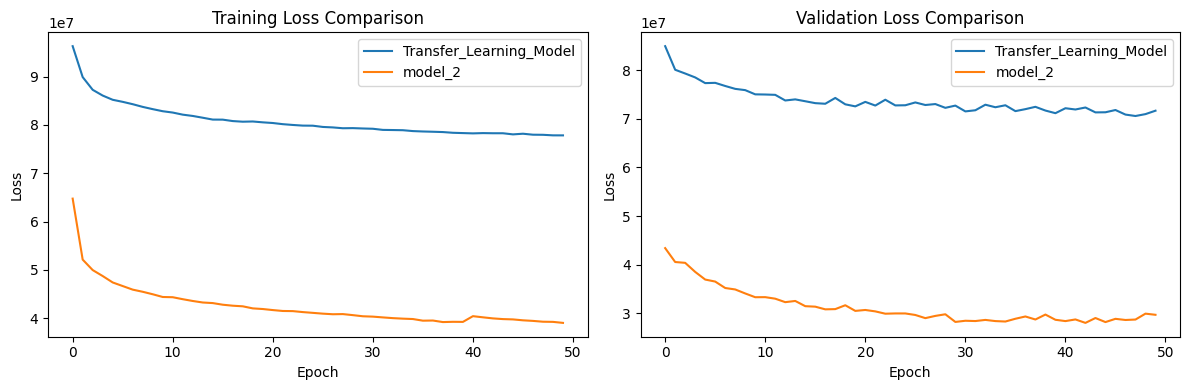

In [29]:
print("\nComparing available trained models...")
compare_models(['Transfer_Learning_Model', 'model_2'])


In [30]:
!pip install transformers

In [31]:
from transformers import AutoModel
print("Transformers library is successfully installed and ready to use.")

Transformers library is successfully installed and ready to use.


In [46]:
import os
import json
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, Callback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoConfig

# ---------------------------- Utility Functions ---------------------------- #
def save_model_and_history(model, history, model_name):
    """
    Save model and training history.

    Args:
    - model: Trained model to save.
    - history: Training history dictionary.
    - model_name: Name of the model for saving files.
    """
    model_path = f"/content/drive2/MyDrive/Colab Notebooks/saved_models/{model_name}.keras"
    model.save(model_path)

    history_path = f"/content/drive2/MyDrive/Colab Notebooks/saved_models/{model_name}_history.json"
    with open(history_path, 'w') as f:
        json.dump(history, f)  # Use history directly

    print(f"Model and history saved for {model_name}.")


def load_model_and_history(model_name):
    """
    Load a saved model and its training history.

    Args:
    - model_name: Name of the model to load.

    Returns:
    - model: Loaded model.
    - history: Training history dictionary.
    """
    model_path = f"/content/drive2/MyDrive/Colab Notebooks/saved_models/{model_name}.keras"
    history_path = f"/content/drive2/MyDrive/Colab Notebooks/saved_models{model_name}_history.json"

    model = tf.keras.models.load_model(model_path)

    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history = json.load(f)
    else:
        history = None

    print(f"Model and history loaded for {model_name}.")
    return model, history

class SaveHistoryCallback(Callback):
    def __init__(self, model_name):
        """
        Callback to save model and history after each epoch.

        Args:
        - model_name: Name of the model for saving.
        """
        super().__init__()
        self.model_name = model_name
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch to save the model and training history.
        """
        # Update history with logs
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)

        # Save the model and history
        if hasattr(self, 'model') and self.model is not None:
            save_model_and_history(self.model, self.history, self.model_name)

# --------------------- TabTransformer Architecture ------------------------ #

def create_tabtransformer_scratch(input_shape, num_outputs=1):
    """
    Create a TabTransformer-like model from scratch for tabular regression.

    Args:
    - input_shape: Tuple specifying the input shape (features, 1).
    - num_outputs: Number of output neurons (1 for regression).

    Returns:
    - model: Compiled TabTransformer-like model.
    """
    inputs = Input(shape=input_shape)
    x = Dense(128, activation="relu")(inputs)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(num_outputs)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="mse", metrics=["mae"])
    return model

def create_tabtransformer_transfer(input_shape, num_outputs=1):
    """
    Use a pre-trained TabTransformer model for transfer learning.

    Args:
    - input_shape: Tuple specifying the input shape (features, 1).
    - num_outputs: Number of output neurons (1 for regression).

    Returns:
    - model: Compiled pre-trained TabTransformer model with custom layers.
    """
    config = AutoConfig.from_pretrained("google/former-tiny")
    transformer_base = TFAutoModel.from_pretrained("google/former-tiny", config=config)

    inputs = Input(shape=input_shape)
    x = transformer_base(inputs)[0]
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_outputs)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

In [37]:
# ---------------------------- Training Workflow --------------------------- #

# Use the preprocessed data from your problem
# Ensure the file path to the dataset is correctly provided
file_path = '/content/drive2/MyDrive/Colab Notebooks/car_prices.csv'
cars_df = load_data(file_path)

# Calculate age before EDA
cars_df['saledate'] = pd.to_datetime(cars_df['saledate'], utc=True)
cars_df['age'] = cars_df['saledate'].dt.year - cars_df['year']

# Preprocess data for your specific use case
X_train, X_test, y_train, y_test, _, _ = preprocess_data(cars_df)

# Flatten data for compatibility with TabTransformer input
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

# Training parameters
EPOCHS = 50
BATCH_SIZE = 32

# Train TabTransformer from scratch
print("\nTraining TabTransformer model from scratch...")
try:
    model_scratch, history_scratch = load_model_and_history("tabtransformer_scratch")
    initial_epoch = len(history_scratch['loss'])
except:
    model_scratch = create_tabtransformer_scratch(input_shape=(X_train_flat.shape[1],))
    initial_epoch = 0

history_scratch = model_scratch.fit(
    X_train_flat, y_train,
    validation_data=(X_test_flat, y_test),
    epochs=EPOCHS,
    initial_epoch=initial_epoch,
    batch_size=BATCH_SIZE,
    callbacks=[
        SaveHistoryCallback("tabtransformer_scratch"),
        EarlyStopping(patience=5, restore_best_weights=True)
    ],
    verbose=1,
)

File loaded successfully with problematic rows skipped.


<ipython-input-37-f23d43181614>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cars_df['saledate'] = pd.to_datetime(cars_df['saledate'], utc=True)
<ipython-input-34-1eb622badb7e>:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=relevant_cols, inplace=True)
<ipython-input-34-1eb622badb7e>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')
<ip


Training TabTransformer model from scratch...
Epoch 1/50
11801/11822 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88168120.0000 - mae: 6500.8408Model and history saved for tabtransformer_scratch.
11822/11822 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 88129896.0000 - mae: 6499.0649 - val_loss: 48885652.0000 - val_mae: 4330.2871
Epoch 2/50
11797/11822 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50029616.0000 - mae: 4666.3003Model and history saved for tabtransformer_scratch.
11822/11822 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 50028956.0000 - mae: 4666.2329 - val_loss: 41811540.0000 - val_mae: 4092.1287
Epoch 3/50
11818/11822 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47987824.0000 - mae: 4533.7285Model and history saved for tabtransformer_scratch.
11822/11822 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 47987836.0000 - mae: 4533.7261 - val_loss: 40612232.0000 - val_mae: 4067.6973
Epoch 4/50
11821/11822 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48059484.0000 - mae: 4482.3721Model and history saved f

In [49]:
def compare_models(model_names):
    """Load and compare the training histories of the specified models."""
    histories = []
    display_names = []

    # Path to the directory where histories are saved
    history_dir = "/content/drive2/MyDrive/Colab Notebooks/saved_models/"

    # Load each model's history
    for name in model_names:
        history_path = os.path.join(history_dir, f"{name}_history.json")
        if os.path.exists(history_path):
            with open(history_path, 'r') as f:
                history = json.load(f)
                histories.append(history)
                display_names.append(name)
        else:
            print(f"History file not found for model: {name}")

    # Plot if there are at least two histories
    if len(histories) > 1:
        plt.figure(figsize=(12, 4))

        # Plot training loss comparison
        plt.subplot(1, 2, 1)
        for i, hist in enumerate(histories):
            if 'loss' in hist:
                plt.plot(hist['loss'], label=f"{display_names[i]} Training")
        plt.title('Training Loss Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot validation loss comparison
        plt.subplot(1, 2, 2)
        for i, hist in enumerate(histories):
            if 'val_loss' in hist:
                plt.plot(hist['val_loss'], label=f"{display_names[i]} Validation")
        plt.title('Validation Loss Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough histories found for comparison.")

In [50]:
save_history(history_scratch.history, "stateOfArt_Model")



Comparing available trained models...


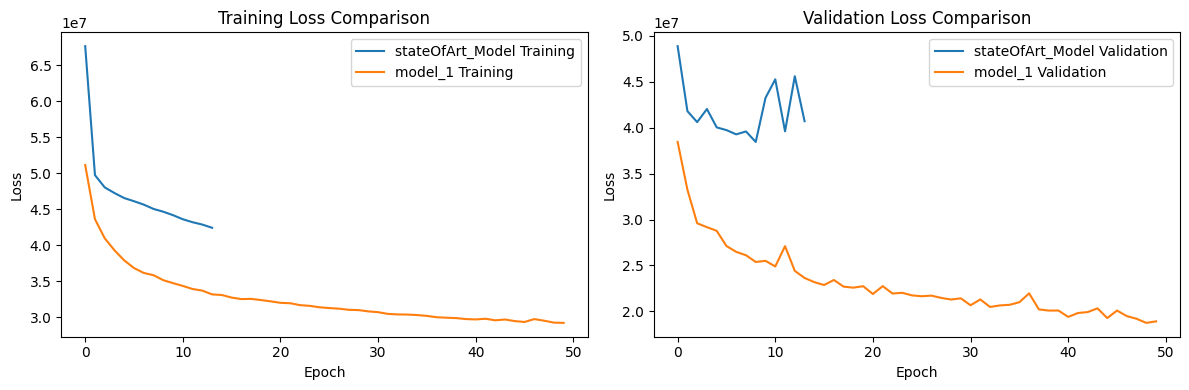

In [51]:
print("\nComparing available trained models...")
compare_models(['stateOfArt_Model', 'model_1'])